<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/Modeling_and_Prediction_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM BASELINE MODEL

In diesem Skript wird ein erstes Modell erzeugt, um aus den gemssenen Globalstrahlungsdaten den UVI zu berechen.

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow
!pip install keras

In [3]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Funktionen:

In [4]:
# sMAPE Funktion zum brechnen des symmetric mean absolute percentage error
def smape(y_true, y_pred):
    diff = K.abs(y_true - y_pred)
    denom = K.abs(y_true) + K.abs(y_pred)
    return 200.0 * K.mean(diff / (denom + K.epsilon()))

## Import

In [7]:
# Pfad zur CSV-Datei auf Google-Drive
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'
folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

In [51]:
# Pfad zum Abspeichern des trainierten Modells in Google-Drive

model_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/full_model.keras'
weights_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_weights.weights.h5'

# Pfad für den Testdatensatz

testdata_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata.csv'

# Pfad für die Logdatei

text_file_path = "/content/drive/MyDrive/Colab_Notebooks/LSTM_Model/model_results.txt"

In [9]:
# Import der Messdaten
df_Messdaten = pd.read_csv(folder_import + name_Messwerte)

In [10]:
# Import der Vorhersagedaten
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)

In [11]:
# Konvertiere die Zeitspalten in ein gemeinsames Format und führe einen Merge der Datensätze durch
df_Messdaten['Datetime'] = pd.to_datetime(df_Messdaten['Datetime'])
df_Vorhersage['Datetime'] = pd.to_datetime(df_Vorhersage['Datetime'])

In [12]:
# Spalten in den Messdaten
df_Messdaten.columns

Index(['Datetime', 'Observation_period', 'Clear_sky_GHI', 'Clear_sky_BHI',
       'GHI', 'BHI', 'UVI', 'UVA', 'UVB', 'erythem', 'Datum', 'Uhrzeit',
       'Messzeitpunkt', 'ghi', 'Dif', 'Glo_SPLite', 'Dir', 'Temp',
       'DiffGreater2', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos',
       'Date', 'Hour'],
      dtype='object')

## Config

In [54]:
model_name = "Baseline_LSTM_ghi"

In [13]:
model_config = {
    "units_1": 64,
    "units_2": 32,
    "dropout_rate": 0.1,
    "final_activation": "linear"
}

In [14]:
training_config = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "metrics": [
        "mse",
        "mae",
        "mape",
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
}

In [15]:
fit_config = {
    "epochs": 5,
    "batch_size": 32,
    "sequence_length": 16
}

## Setup

In [16]:
# Beispiel: Nur 'SZA' als Feature und 'UVI' als Label
columns_X = ['ghi']
columns_y = ['UVI']

df = df_Messdaten.copy()  # deine Messdaten

total_length = len(df)
train_size   = round(total_length * 0.80)
val_size     = round(total_length * 0.10)
test_size    = total_length - train_size - val_size  # restliche 10%

# Skaliere X und Y separat (immer zuerst nur auf dem Trainingsbereich fitten!)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 1) Nur Trainingsdatensatz extrahieren
train_df = df.iloc[:train_size]
# Fit des Scalers NUR auf Trainingsdaten
train_df[columns_X] = scaler_X.fit_transform(train_df[columns_X])
train_df[columns_y] = scaler_y.fit_transform(train_df[columns_y])

# 2) Für Validation
val_df = df.iloc[train_size : train_size + val_size].copy()
val_df[columns_X] = scaler_X.transform(val_df[columns_X])
val_df[columns_y] = scaler_y.transform(val_df[columns_y])

# 3) Für Test
test_df = df.iloc[train_size + val_size :].copy()
test_df[columns_X] = scaler_X.transform(test_df[columns_X])
test_df[columns_y] = scaler_y.transform(test_df[columns_y])

# Kontrolle
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (77386, 26)
Val: (9673, 26)
Test: (9673, 26)


<ipython-input-16-f8bf0a26c930>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_X] = scaler_X.fit_transform(train_df[columns_X])
<ipython-input-16-f8bf0a26c930>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_y] = scaler_y.fit_transform(train_df[columns_y])


In [17]:
def create_sequence(X, y, seq_length):
    sequences = []
    labels = []
    for stop_idx in range(seq_length, len(X)):
        x_seq = X.iloc[stop_idx-seq_length:stop_idx].values  # (seq_length, num_features)
        y_label = y.iloc[stop_idx]                           # Wert am Zeitpunkt 'stop_idx'
        sequences.append(x_seq)
        labels.append(y_label)
    return np.array(sequences), np.array(labels)

In [18]:
def create_sequence_OneStepAhead(X, y, seq_length):
    sequences = []
    labels = []
    # bis len(X)-1, damit "stop_idx + 1" nicht out-of-range ist
    for stop_idx in range(seq_length, len(X)-1):
        x_seq = X.iloc[stop_idx-seq_length:stop_idx].values
        y_label = y.iloc[stop_idx + 1]  # => label ist der nächste Zeitschritt
        sequences.append(x_seq)
        labels.append(y_label)
    return np.array(sequences), np.array(labels)

In [19]:
sequence_len = fit_config["sequence_length"]

X_train_seq, y_train_seq = create_sequence(train_df[columns_X], train_df[columns_y], sequence_len)
X_val_seq,   y_val_seq   = create_sequence(val_df[columns_X],   val_df[columns_y],   sequence_len)
X_test_seq,  y_test_seq  = create_sequence(test_df[columns_X],  test_df[columns_y],  sequence_len)

print(X_train_seq.shape, y_train_seq.shape)
print(X_val_seq.shape,   y_val_seq.shape)
print(X_test_seq.shape,  y_test_seq.shape)

(77370, 16, 1) (77370, 1)
(9657, 16, 1) (9657, 1)
(9657, 16, 1) (9657, 1)


In [20]:
input_shape = (16, 1)

In [21]:
def build_and_compile_model(model_config, training_config, input_shape):
    """
    Baut ein Keras Sequential Model anhand der übergebenen Konfigurationen
    und kompiliert es mit den Trainingseinstellungen.

    Parameter:
    -----------
    model_config: dict
        Dict mit Keys wie 'units_1', 'units_2', 'dropout_rate', 'final_activation'
    training_config: dict
        Dict mit Keys wie 'loss', 'optimizer', 'metrics'
    input_shape: tuple
        Form deiner Eingabedaten, z.B. (timesteps, features)

    Returns:
    -----------
    model : keras.Model
        Das fertig kompilierte Modell.
    """

    model = Sequential()
    model.add(
        LSTM(
            units=model_config["units_1"],
            return_sequences=True,
            input_shape=input_shape
        )
    )
    model.add(Dropout(model_config["dropout_rate"]))

    # Zweite LSTM-Schicht
    model.add(LSTM(units=model_config["units_2"]))

    # Dense-Ausgangsschicht
    model.add(Dense(1, activation=model_config["final_activation"]))

    # Kompilieren
    model.compile(**training_config)

    return model

In [22]:
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # z.B. (16, 1)

model = build_and_compile_model(
    model_config=model_config,
    training_config=training_config,
    input_shape=input_shape
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=fit_config["epochs"],
    batch_size=fit_config["batch_size"]
)

Epoch 1/5
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - loss: 0.0053 - mae: 0.0435 - mape: 3500.6848 - mse: 0.0053 - rmse: 0.0717 - val_loss: 0.0073 - val_mae: 0.0597 - val_mape: 70.2940 - val_mse: 0.0073 - val_rmse: 0.0852
Epoch 2/5
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - loss: 0.0034 - mae: 0.0355 - mape: 3298.9924 - mse: 0.0034 - rmse: 0.0580 - val_loss: 0.0077 - val_mae: 0.0602 - val_mape: 48.7278 - val_mse: 0.0077 - val_rmse: 0.0877
Epoch 3/5
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 0.0030 - mae: 0.0336 - mape: 4251.5171 - mse: 0.0030 - rmse: 0.0551 - val_loss: 0.0077 - val_mae: 0.0592 - val_mape: 50.3220 - val_mse: 0.0077 - val_rmse: 0.0876
Epoch 4/5
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - loss: 0.0030 - mae: 0.0332 - mape: 2670.1052 - mse: 0.0030 - rmse: 0.0547 - val_loss: 0.0070 - val_mae: 0.0563 - val_mape: 47.5600 - val_mse: 0.0070 - val_rmse: 0.0834
Epoch 5/5
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 0.0028 - mae: 0.0321 - mape: 2180.463

In [24]:
# 2) Evaluieren (Keras-integrierte Metriken)
val_results = model.evaluate(X_val_seq, y_val_seq, verbose=0)
test_results = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print("Model metrics names:", model.metrics_names)

# 3) Vorhersagen für weitere Kennzahlen (z.B. R2-Score)
y_val_pred = model.predict(X_val_seq).flatten()
y_test_pred = model.predict(X_test_seq).flatten()

val_r2  = r2_score(y_val_seq, y_val_pred)
test_r2 = r2_score(y_test_seq, y_test_pred)

# 4) Dictionary bauen
metrics = {
    "val_loss": val_results[0],
    "val_mse":  val_results[1],
    "val_mae":  val_results[2],
    "val_rmse": val_results[3],
    "test_loss": test_results[0],
    "test_mse":  test_results[1],
    "test_mae":  test_results[2],
    "test_rmse": test_results[3],
    "val_r2": val_r2,
    "test_r2": test_r2
}

Model metrics names: ['loss', 'compile_metrics']
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [25]:
# Berechnen des vorhergesagten UVI
y_pred = model.predict(X_test_seq)

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [26]:
y_pred = y_pred.flatten()
y_test_seq = y_test_seq.flatten()

In [27]:
type(y_pred)

numpy.ndarray

In [28]:
# Püfen, ob die Vorhersage den selben Shape hat wie
print(y_pred.shape, y_test_seq.shape)

(9657,) (9657,)


In [29]:
# Abspeichern des trainierten Modells und der Gewichte

model.save(model_path)
model.save_weights(weights_path)

# Abspeichern des Testdatensatzes für eine spätere Auswertung

## Berechnung der Qualitätsparameter:

In [32]:
def compare_model_output(model, X_test, y_test, plot_indices=None):
    """
    Vergleicht den Output des Modells mit den wahren Testdaten.

    Parameter:
    -----------
    model : keras.Model
        Das trainierte Modell.
    X_test : np.array
        Die Eingabedaten (Sequenzen) für den Test.
    y_test : np.array
        Die tatsächlichen Zielwerte (Labels) für den Test.
    plot_indices : tuple or list (optional)
        Falls angegeben, z.B. (start, end), wird nur dieser Abschnitt für einen Detailplot verwendet.
    """

    # Vorhersage berechnen
    y_pred = model.predict(X_test)
    # Arrays abflachen für leichtere Handhabung
    y_pred = y_pred.flatten()
    y_test = y_test.flatten()

    # Metriken berechnen
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Ergebnis ausgeben
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Gesamten Vergleich plotten
    plt.figure(figsize=(12, 4))
    plt.plot(y_pred, label='Vorhersage', alpha=0.7)
    plt.plot(y_test, label='Tatsächlicher Wert', alpha=0.7)
    plt.title('Vergleich Vorhersage vs. Tatsächlicher Wert')
    plt.legend()
    plt.show()

    # Optionaler Detailplot für einen Index-Bereich
    if plot_indices is not None:
        start, end = plot_indices
        plt.figure(figsize=(12, 4))
        plt.plot(np.arange(start, end), y_pred[start:end], label='UVI Vorhersage', alpha=0.7)
        plt.plot(np.arange(start, end), y_test[start:end], label='UVI Messung', alpha=0.7)
        plt.title(f'Detailplot (Index {start} - {end})')
        plt.legend()
        plt.show()

302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Mean Squared Error (MSE): 0.0089
Mean Absolute Error (MAE): 0.0629


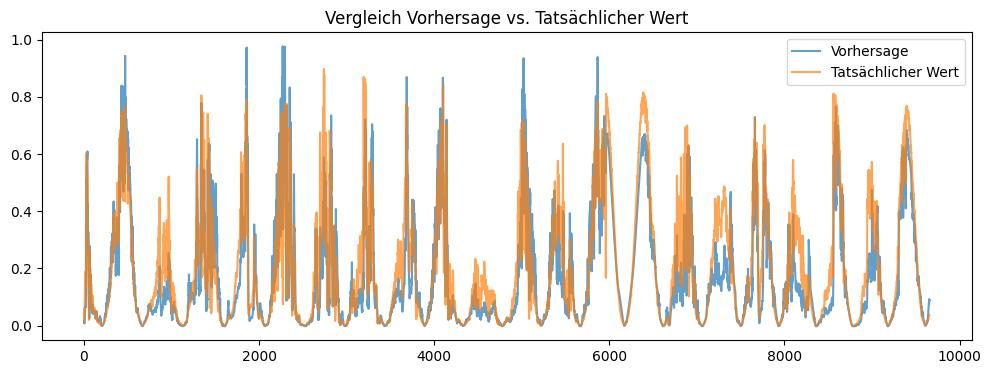

In [33]:
compare_model_output(model, X_test_seq, y_test_seq, plot_indices=None)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error (MSE): 0.0039
Mean Absolute Error (MAE): 0.0390


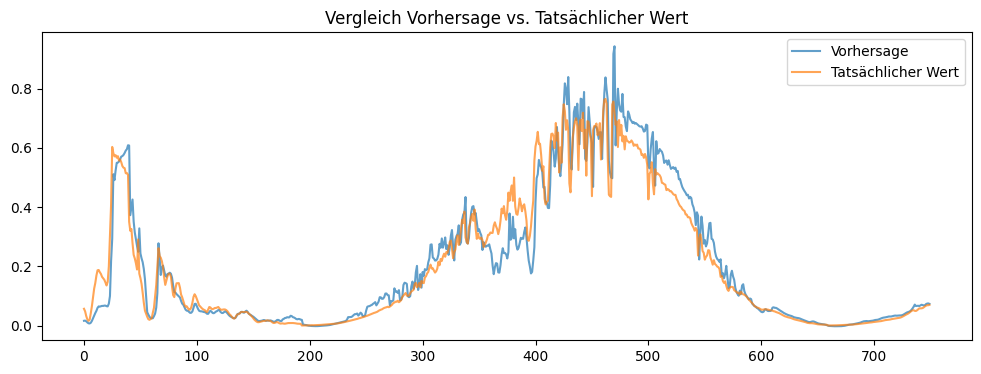

In [34]:
compare_model_output(model, X_test_seq[:750], y_test_seq[:750], plot_indices=None)

In [39]:
def plot_largest_deviation(y_pred, y_true, window=250):
    """
    Findet die größte Abweichung zwischen Vorhersage und Messwerten und plottet
    den Bereich von [i-window, i+window] um diesen Index herum.

    Parameter:
    -----------
    y_pred : np.array
        Array der Vorhersagewerte (z.B. Modelloutput).
    y_true : np.array
        Array der gemessenen True-Werte (Labels).
    window : int, optional (default=250)
        Anzahl an Werten vor und nach dem Index der größten Abweichung,
        die im Detailplot dargestellt werden sollen.

    Returns:
    -----------
    None (erstellt ein Plot).
    """

    # Sicherstellen, dass beide Arrays gleich lang sind
    if len(y_pred) != len(y_true):
        raise ValueError(f"Inkonsistente Längen: y_pred={len(y_pred)}, y_true={len(y_true)}")

    # Index der größten Abweichung bestimmen
    diff = np.abs(y_pred - y_true)
    max_idx = np.argmax(diff)

    # Anzeigebereich für den Plot definieren (Begrenzung beachten)
    start_idx = max(0, max_idx - window)
    end_idx = min(len(y_pred), max_idx + window)

    # Plot erstellen
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(start_idx, end_idx), y_true[start_idx:end_idx],
             label='Messwerte (y_val)', alpha=0.7)
    plt.plot(np.arange(start_idx, end_idx), y_pred[start_idx:end_idx],
             label='Vorhersage (y_pred)', alpha=0.7)
    # Hervorhebung des Punktes mit größter Abweichung
    plt.scatter(max_idx, y_true[max_idx], color='red', s=80, marker='x', label='Größte Abweichung')

    plt.title(f'Größte Abweichung bei Index={max_idx} (Abweichung={diff[max_idx]:.4f})')
    plt.xlabel('Index')
    plt.ylabel('Wert')
    plt.legend()
    plt.show()

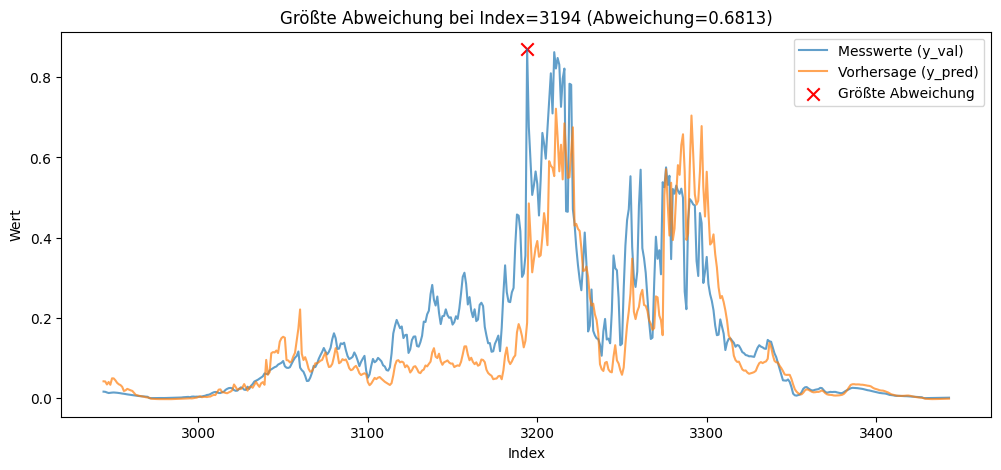

In [40]:
plot_largest_deviation(y_pred, y_test_seq)

In [41]:
print(y_pred, y_test_seq)

[0.01607212 0.01680115 0.01425292 ... 0.09238789 0.08552711 0.08711551] [0.05666824 0.04794793 0.03181067 ... 0.03678404 0.03708798 0.03657019]


In [45]:
def log_model_results_to_csv(
    model_name,
    model_config,        # Dictionary mit Modell-Hyperparametern
    training_config,     # Dictionary mit Compile-Einstellungen (model.compile)
    fit_config,          # <--- NEU: Dictionary mit fit-Parametern (epochs, batch_size, sequence_length)
    metrics,             # Dictionary mit erzielten Metriken
    csv_path="model_results.csv"
):

    # 1) Zusammenführen aller Informationen in ein Dictionary
    results_dict = {
        "model_name": model_name
    }

    # Modell-Konfigurationswerte hinzufügen
    for k, v in model_config.items():
        results_dict[f"model_config.{k}"] = v

    # Trainings-Konfigurationswerte (compile) hinzufügen
    for k, v in training_config.items():
        results_dict[f"training_config.{k}"] = str(v)

    # Fit-Konfigurationswerte (fit) hinzufügen
    for k, v in fit_config.items():
        results_dict[f"fit_config.{k}"] = v

    # Metrics hinzufügen
    results_dict.update(metrics)

    # 2) Anzeige in der Konsole
    print("=== Model Results ===")
    for key, value in results_dict.items():
        print(f"{key}: {value}")
    print("======================\n")

    # 3) In einen DataFrame umwandeln (eine Zeile pro Modell)
    df_results = pd.DataFrame([results_dict])

    # 4) Schreiben oder Anhängen in die CSV
    if not os.path.exists(csv_path):
        df_results.to_csv(csv_path, index=False)
    else:
        df_results.to_csv(csv_path, mode='a', index=False, header=False)

In [46]:
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

In [47]:
log_model_results_to_csv(
    model_name="Baseline LSTM",
    model_config=model_config,
    training_config=training_config,
    fit_config=fit_config,        # <--- Neues Argument
    metrics=metrics,
    csv_path="model_results.csv"
)

=== Model Results ===
model_name: Baseline LSTM
model_config.units_1: 64
model_config.units_2: 32
model_config.dropout_rate: 0.1
model_config.final_activation: linear
training_config.loss: mean_squared_error
training_config.optimizer: adam
training_config.metrics: ['mse', 'mae', 'mape', <RootMeanSquaredError name=rmse>]
fit_config.epochs: 5
fit_config.batch_size: 32
fit_config.sequence_length: 16
val_loss: 0.007743313908576965
val_mse: 0.007743313908576965
val_mae: 0.05897708237171173
val_rmse: 44.57095718383789
test_loss: 0.00892695877701044
test_mse: 0.00892695877701044
test_mae: 0.06294387578964233
test_rmse: 60.592220306396484
val_r2: 0.7900590413070319
test_r2: 0.7836071803082321



In [55]:
def log_model_results_to_txt(
    file_path,
    model_name,
    model_config,
    training_config,
    fit_config,
    metrics
):

    # 1) Dictionarys in einem zusammenfassen (optional),
    #    hier schreiben wir aber direkt Zeile für Zeile ins File.
    #    Mit 'a' (append) hängen wir an bestehende Datei an.
    with open(file_path, 'a') as f:
        f.write("=== Model Results ===\n")
        f.write(f"model_name: {model_name}\n")

        # model_config
        for k, v in model_config.items():
            f.write(f"model_config.{k}: {v}\n")

        # training_config
        for k, v in training_config.items():
            f.write(f"training_config.{k}: {v}\n")

        # fit_config
        for k, v in fit_config.items():
            f.write(f"fit_config.{k}: {v}\n")

        # metrics
        for k, v in metrics.items():
            f.write(f"{k}: {v}\n")

        f.write("======================\n\n")  # Leerzeile am Ende

In [56]:
log_model_results_to_txt(
    file_path=text_file_path,
    model_name=model_name,
    model_config=model_config,
    training_config=training_config,
    fit_config=fit_config,
    metrics=metrics
)